In [1]:
import pandas as pd
import numpy as np
#from shapely.geometry import  Point
#import geopandas as gpd
import matplotlib.pyplot as plt
#import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
#import contextily as ctx
#import geoplot as gplt
#import lightgbm as lgb
#import eli5
#from eli5.sklearn import PermutationImportance
#from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
#from pdpbox import pdp, get_dataset, info_plots
#import shap

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential 
from keras.layers import Dense
from keras.initializers import GlorotUniform
from keras.initializers import HeUniform
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax, Nadam, Ftrl

2024-09-29 11:46:54.555715: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 11:46:54.555822: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 11:46:54.557993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 11:46:54.780100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


-------------------------


In [3]:
ds = pd.read_csv('datasets/SanFranciscoCriminality.csv', parse_dates=['Dates'])
ds.drop(columns=['Descript'], inplace=True)
ds = ds.groupby('Category').filter(lambda x : len(x)>60000)
# stampare il numero di categorie
print(ds['Category'].value_counts())
encoder = OrdinalEncoder()
ds['Category'] = encoder.fit_transform(ds[['Category']])

train_df, test_df = train_test_split(ds, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_x = train_df.drop(columns=['Category'])
train_y = train_df['Category']

val_x = val_df.drop(columns=['Category'])
val_y = val_df['Category']

test_x = test_df.drop(columns=['Category'])
test_y = test_df['Category']    

In [11]:
resolution = []
resolution.append(train_x['Resolution'].str.split(',').apply(len))
print(np.unique(np.array(resolution)))

def second_resolution(elem):
    return elem.split(',')[1] if len(elem.split(',')) > 1 else 'NONE'

def resolution(dataset):
    dataset['Resolution_1'] = dataset['Resolution'].str.split(',').str[0]
    dataset['Resolution_2'] = dataset['Resolution'].map(second_resolution)
    return dataset.drop(columns=['Resolution'])
        

[1 2]


In [12]:
train_x.loc[~train_x['Y'].astype(str).str.startswith('37'), 'Y'] = np.nan
train_x.loc[~train_x['X'].astype(str).str.startswith('-122'), 'X'] = np.nan

imp = SimpleImputer(strategy='mean')

for district in train_x['PdDistrict'].unique():
    train_x.loc[train_x['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(train_x.loc[train_x['PdDistrict'] == district, ['X', 'Y']])
# calcolare la distanza euclidea di X e Y rispetto al centro di San Francisco a coordinate 37.774929 -122.419416

def feature_engineering(dataset):
    dataset = resolution(dataset)
    dataset['Date'] = pd.to_datetime(dataset['Dates'].dt.date)
    dataset['n_days'] = (dataset['Date'] - dataset['Date'].min()).apply(lambda x: x.days)
    dataset['Day'] = dataset['Dates'].dt.day
    dataset['DayOfWeek'] = dataset['Dates'].dt.weekday
    dataset['Month'] = dataset['Dates'].dt.month
    dataset['Year'] = dataset['Dates'].dt.year
    dataset['Hour'] = dataset['Dates'].dt.hour
    dataset['Minute'] = dataset['Dates'].dt.minute
    dataset['Block'] = dataset['Address'].str.contains('block', case=False)

    dataset['DayPhase']=0
    dataset.loc[(dataset['Hour']<=12) & (dataset['Hour']>=5),'DayPhase']=1
    dataset.loc[(dataset['Hour']<=18) & (dataset['Hour']>=13),'DayPhase']=2
    dataset.loc[(dataset['Hour']<=23) & (dataset['Hour']>=19),'DayPhase']=3
    dataset.loc[(dataset['Hour']<=4) & (dataset['Hour']>=0),'DayPhase']=4

    dataset['distance'] = np.sqrt((dataset['X'] - 122.419416)**2 + (dataset['Y'] - 37.774929)**2)
    
    dataset.drop(columns=['Dates','Date','Address'], inplace=True)
        
    return dataset

def fs(dataset, dataset_y):
    str_path = 'objects/SFCriminality.npy'
    if not os.path.exists(str_path):
        dataset['label'] = dataset_y
        correlation_matrix=dataset.corr()
        print(correlation_matrix['label'].sort_values(ascending=False))
        features = correlation_matrix['label'][(correlation_matrix['label']>=0.05) | (correlation_matrix['label']<=-0.05)].index
        features = features.drop('label')
        print(correlation_matrix['label'].sort_values(ascending=False))
        print(features)

        correlation_matrix=dataset.corr()
        correlation_matrix
        plt.figure(figsize=(20, 10))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Heatmap')
        plt.show()
        
        np.save(str_path, features)
    features = np.load(str_path, allow_pickle=True)
    return dataset[features]

def encoding(dataset, ohe):
    # Chiamata al preprocessing
    dataset = feature_engineering(dataset)
   
    num_cols = dataset.select_dtypes(exclude=['object', 'bool']).columns
    cat_cols = dataset.select_dtypes(include=['object', 'bool']).columns

    # Applica lo scaling ai dati numerici
    scaler = StandardScaler()
    dataset[num_cols] = scaler.fit_transform(dataset[num_cols])

    # Applica l'encoding ai dati categoriali nella lista ord_list
    encoder = OrdinalEncoder()
    dataset[cat_cols] = encoder.fit_transform(dataset[cat_cols])
    dataset = fs(dataset, train_y)
    for col in ohe:
        print(col, dataset.columns)
        if col in dataset.columns:
            dataset = pd.get_dummies(dataset, columns=ohe)

    return dataset.astype(float), scaler, encoder

label           1.000000
Minute          0.090818
PdDistrict      0.003804
X               0.002486
distance       -0.002484
Day            -0.013867
Year           -0.014316
n_days         -0.015810
Month          -0.017797
Hour           -0.025539
DayOfWeek      -0.036511
DayPhase       -0.051990
Y              -0.061909
Block          -0.169869
Resolution_2   -0.252369
Resolution_1   -0.310557
Name: label, dtype: float64
label           1.000000
Minute          0.090818
PdDistrict      0.003804
X               0.002486
distance       -0.002484
Day            -0.013867
Year           -0.014316
n_days         -0.015810
Month          -0.017797
Hour           -0.025539
DayOfWeek      -0.036511
DayPhase       -0.051990
Y              -0.061909
Block          -0.169869
Resolution_2   -0.252369
Resolution_1   -0.310557
Name: label, dtype: float64
Index(['Y', 'Resolution_1', 'Resolution_2', 'Minute', 'Block', 'DayPhase'], dtype='object')


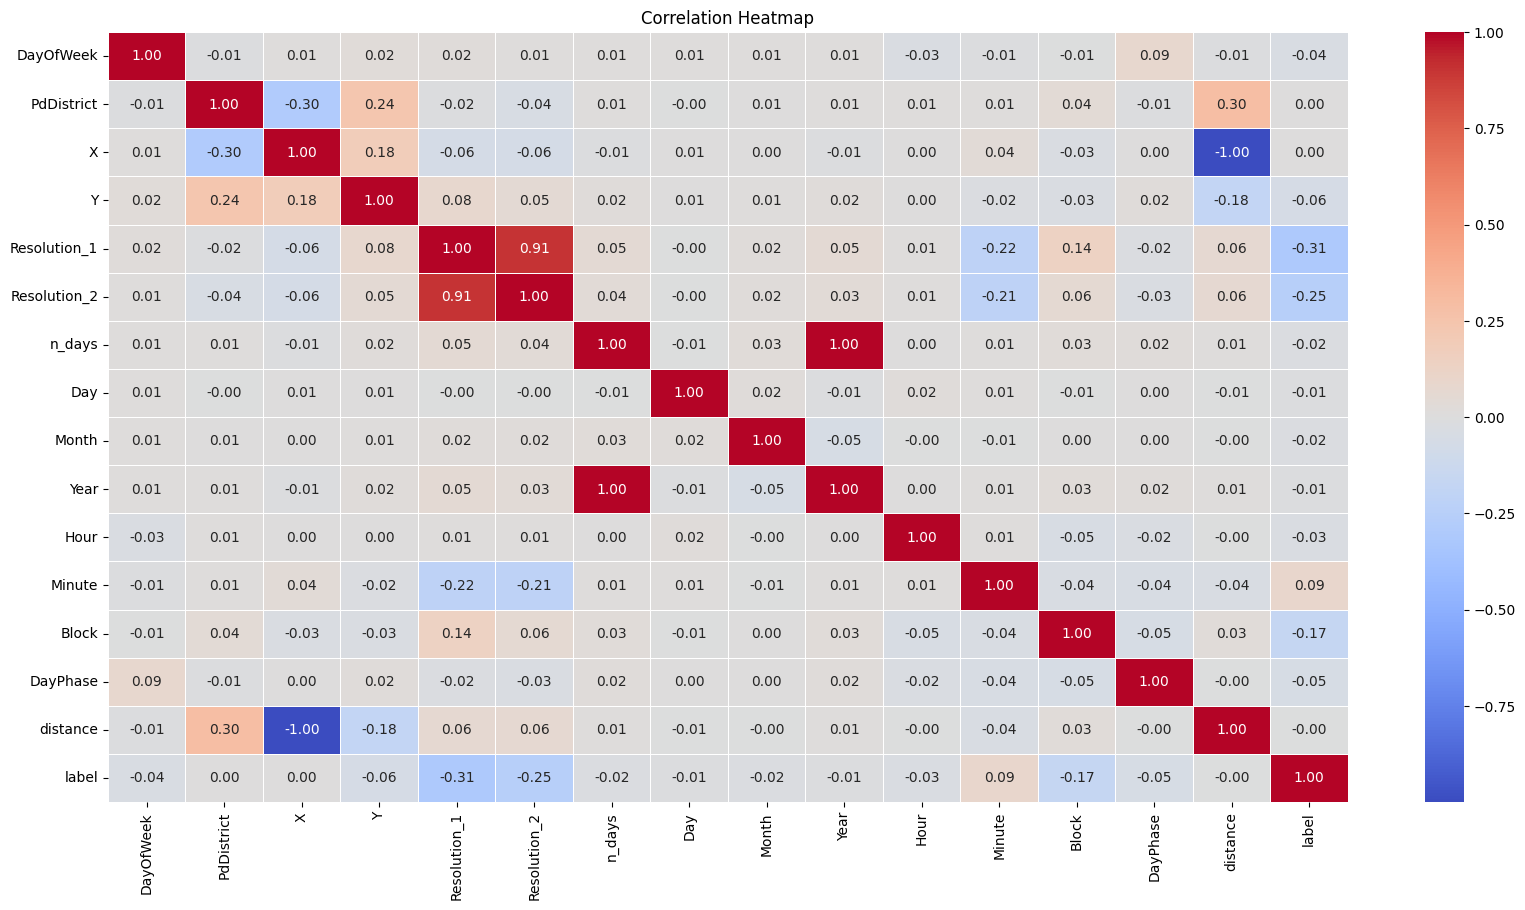

Block Index(['Y', 'Resolution_1', 'Resolution_2', 'Minute', 'Block', 'DayPhase'], dtype='object')


In [13]:
train_x, scaler, encoder = encoding(train_x, ['Block'])

def preproc_test_val(dataset, scaler, encoder, ohe):
    dataset.loc[~dataset['Y'].astype(str).str.startswith('37'), 'Y'] = np.nan
    dataset.loc[~dataset['X'].astype(str).str.startswith('-122'), 'X'] = np.nan

    for district in dataset['PdDistrict'].unique():
        dataset.loc[dataset['PdDistrict'] == district, ['X', 'Y']] = imp.transform(dataset.loc[dataset['PdDistrict'] == district, ['X', 'Y']])
    dataset = feature_engineering(dataset)

    cat_cols = dataset.select_dtypes(include=['object', 'bool']).columns
    num_cols = dataset.select_dtypes(exclude=['object', 'bool']).columns

    dataset[num_cols] = scaler.transform(dataset[num_cols])
    dataset[cat_cols] = encoder.transform(dataset[cat_cols])
    features = np.load('objects/SFCriminality.npy', allow_pickle=True)
    dataset = dataset[features]
    dataset = dataset.astype(float)
    for col in ohe:
        if col in dataset.columns:
            dataset = pd.get_dummies(dataset, columns=ohe)
    return dataset.astype(float)

val_x = preproc_test_val(val_x, scaler, encoder, ['Block'])
test_x = preproc_test_val(test_x, scaler, encoder, ['Block'])


In [14]:
print(train_y.dtypes)
print(train_x.dtypes)
print(val_y.dtypes)
print(val_x.dtypes)

float64
Y               float64
Resolution_1    float64
Resolution_2    float64
Minute          float64
DayPhase        float64
Block_0.0       float64
Block_1.0       float64
dtype: object
float64
Y               float64
Resolution_1    float64
Resolution_2    float64
Minute          float64
DayPhase        float64
Block_0.0       float64
Block_1.0       float64
dtype: object


In [15]:
print(train_y.shape)

(300967,)


In [16]:
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

classes = np.unique(train_y).size


def model_builder(hp):
    model = Sequential()

    # Tune the number of units and activation function for each Dense layer
    for i in range(hp.Int('num_layers', 2, 5, default=4)):
        hp_units = hp.Int(f'units_{i}', min_value=16, max_value=512, step=16)
        hp_activation = hp.Choice(f'activation_{i}', values=['PReLU','LeakyReLU','relu', 'tanh', 'sigmoid', 'softmax'])

        model.add(Dense(units=hp_units, activation=hp_activation, kernel_initializer=he_normal))

    # Output layer
    model.add(Dense(classes, activation='softmax', kernel_initializer=glorot_normal))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tune the initializer for the Dense layers
    hp_initializer = hp.Choice('initializer', values=['he_normal', 'glorot_normal'])

    if hp_initializer == 'he_normal':
        initializer = he_normal()
    else:
        initializer = glorot_normal()

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='multi_layer_tuning')

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_x, train_y, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}.
""")

ModuleNotFoundError: No module named 'keras_tuner'

In [204]:
print(best_hps.values)

{'num_layers': 3, 'units_0': 480, 'activation_0': 'relu', 'units_1': 192, 'activation_1': 'PReLU', 'units_2': 368, 'activation_2': 'PReLU', 'units_3': 32, 'activation_3': 'softmax', 'learning_rate': 0.001, 'initializer': 'glorot_normal', 'units_4': 96, 'activation_4': 'PReLU', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}


[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 480)               3840      
                                                                 
 dense_8 (Dense)             (None, 192)               92544     
                                                                 
 dense_9 (Dense)             (None, 368)               71392     
                                                                 
 dense_10 (Dense)            (None, 4)                 1476      
                                                                 
Total params: 169252 (661.14 KB)
Trainable params: 169252 (661.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
588/588 [============================

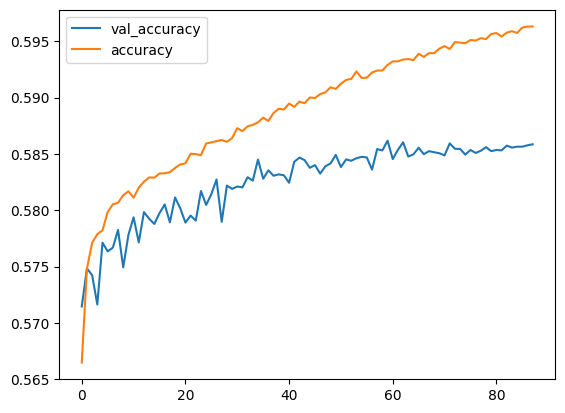

In [205]:
EPOCHS = 1000
BATCH_SIZE = 512
DROPOUT = 0.1
classes = np.unique(train_y).size

# fare one hot encoding delle labels con un encoder per poterlo poi applicare al validation set
encoder = OneHotEncoder()
train_y = encoder.fit_transform(train_y.values.reshape(-1, 1)).toarray()
val_y = encoder.transform(val_y.values.reshape(-1, 1)).toarray()
print(train_y)
np.random.seed(42)
tf.random.set_seed(42)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(480, activation='relu', input_dim=train_x.shape[-1]))
model.add(Dense(192,  kernel_initializer='he_normal', activation='PReLU'))    
model.add(Dense(368,  kernel_initializer='he_normal', activation='PReLU'))    
model.add(Dense(classes,  kernel_initializer='normal', activation='softmax'))   

# summary
model.summary()
# Compiling the NN
initial_learning_rate = 0.01
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/100)
steps_per_epoch = int(train_x.shape[0]/BATCH_SIZE)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Train the NN
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_cb],
                    validation_data=(val_x, val_y))

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.show()
